## GMM 최종

### best parameter(어디쉐어 - 보간 O)

최적의 컴포넌트 수: 20
최적의 공분산 타입: full
최적의 BIC 점수: -90009.20443390089
최적의 임계값: -4.984449351351613
AUC: 1.0


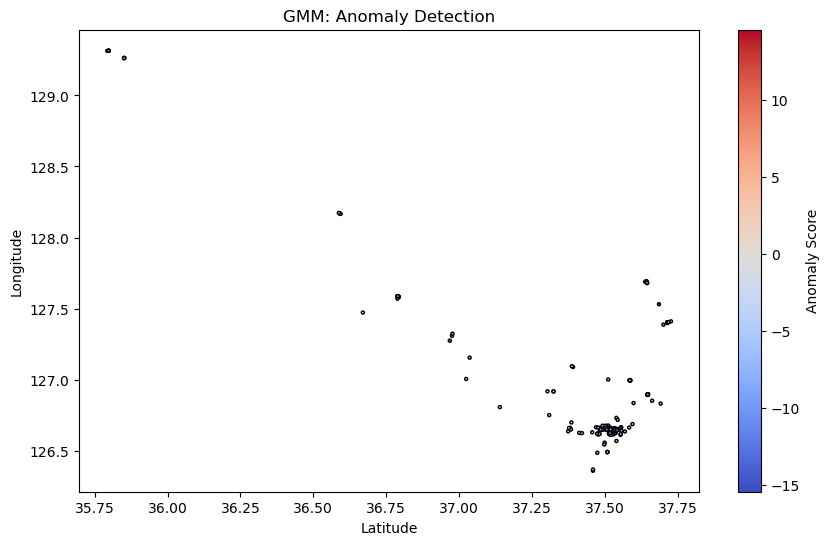

In [25]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\어디쉐어\___ecfd1086a6934ae08b555b3ae880d31e'

# 보간 함수 정의
def interpolate_path(path, num_points=10):
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    start_time_labels = [point[2] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    interp_start_TL = interp1d(distances, start_time_labels, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    new_TL = interp_start_TL(new_distances)
    return np.column_stack((new_latitudes, new_longitudes, new_TL))

# 모든 CSV 파일을 읽어 결합
all_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        
        # 보간 적용
        path = df[['lat', 'lng', 'TL']].values
        interpolated_data = interpolate_path(path)
        
        # 보간된 데이터를 DataFrame으로 변환하여 추가
        interpolated_df = pd.DataFrame(interpolated_data, columns=['lat', 'lng', 'TL'])
        all_data.append(interpolated_df)

# 모든 데이터를 하나의 DataFrame으로 결합
data = pd.concat(all_data, ignore_index=True)

# 결합된 데이터에서 결측치 제거
data = data.dropna(subset=['lat', 'lng', 'TL'])

# lat, lng, TL 열만 선택하여 새로운 데이터 생성
X = data[['lat', 'lng', 'TL']]

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# BIC를 사용하여 최적의 n_components와 covariance_type 찾기
def select_best_gmm(data, n_components_range, covariance_types):
    best_bic = np.inf
    best_n_components = None
    best_covariance_type = None
    best_gmm = None
    
    # n_components와 covariance_type을 모두 반복하며 최적의 조합 찾기
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            bic = gmm.bic(data)
            
            if bic < best_bic:
                best_bic = bic
                best_n_components = n_components
                best_covariance_type = covariance_type
                best_gmm = gmm
    
    return best_n_components, best_covariance_type, best_gmm, best_bic

# n_components의 범위 설정 (예시로 1부터 20까지)
n_components_range = range(1, 21)
covariance_types = ['full', 'tied', 'diag', 'spherical']  # 공분산 타입 목록

# 최적의 n_components와 covariance_type 선택
best_n_components, best_covariance_type, best_gmm, best_bic = select_best_gmm(X_train, n_components_range, covariance_types)

print(f"최적의 컴포넌트 수: {best_n_components}")
print(f"최적의 공분산 타입: {best_covariance_type}")
print(f"최적의 BIC 점수: {best_bic}")

# 테스트 데이터에 모델 적용
test_scores = best_gmm.score_samples(X_test)

# 이상 탐지 점수에 기반한 가상의 레이블 생성 (예: 상위 5%를 이상으로 간주)
threshold = np.percentile(test_scores, 5)
y_test = (test_scores < threshold).astype(int)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # GMM은 score가 높을수록 정상으로 간주되므로 부호를 반대로
auc = roc_auc_score(y_test, -test_scores)  # AUC 계산

# 최적의 임계값 찾기 (기본적으로 FPR과 TPR의 차이가 최대가 되는 임계값을 선택)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold}")
print(f"AUC: {auc}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test['lat'], X_test['lng'], c=-test_scores, cmap='coolwarm', s=5, edgecolor='k')
plt.colorbar(label='Anomaly Score')
plt.title('GMM: Anomaly Detection')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

### best parameter(어디쉐어 - 보간 X)

Best number of components: 19
Best covariance type: full
Best BIC score: -270680.1270189837
Optimal threshold: -11.632648255009332
AUC: 1.0


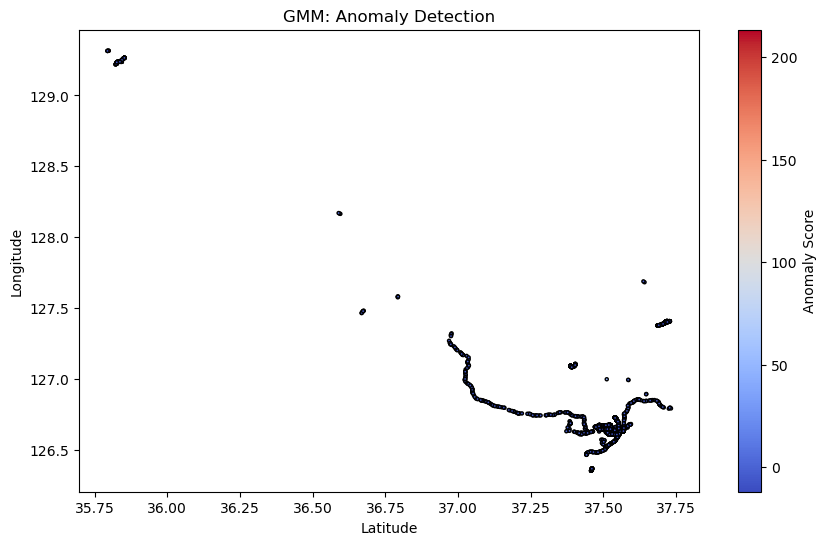

In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\어디쉐어\___ecfd1086a6934ae08b555b3ae880d31e'

# 모든 CSV 파일을 읽어 결합
all_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        all_data.append(df)

# 모든 데이터를 하나의 DataFrame으로 결합
data = pd.concat(all_data, ignore_index=True)

# 결합된 데이터에서 결측치 제거
data = data.dropna(subset=['lat', 'lng', 'TL'])

# lat, lng, TL 열만 선택하여 새로운 데이터 생성
X = data[['lat', 'lng', 'TL']]

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# BIC를 사용하여 최적의 n_components와 covariance_type 찾기
def select_best_gmm(data, n_components_range, covariance_types):
    best_bic = np.inf
    best_n_components = None
    best_covariance_type = None
    best_gmm = None
    
    # n_components와 covariance_type을 모두 반복하며 최적의 조합 찾기
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            bic = gmm.bic(data)
            
            if bic < best_bic:
                best_bic = bic
                best_n_components = n_components
                best_covariance_type = covariance_type
                best_gmm = gmm
    
    return best_n_components, best_covariance_type, best_gmm, best_bic

# n_components의 범위 설정 (예시로 1부터 20까지)
n_components_range = range(1, 21)
covariance_types = ['full', 'tied', 'diag', 'spherical']  # 공분산 타입 목록

# 최적의 n_components와 covariance_type 선택
best_n_components, best_covariance_type, best_gmm, best_bic = select_best_gmm(X_train, n_components_range, covariance_types)

print(f"Best number of components: {best_n_components}")
print(f"Best covariance type: {best_covariance_type}")
print(f"Best BIC score: {best_bic}")

# 테스트 데이터에 모델 적용
test_scores = best_gmm.score_samples(X_test)

# 이상 탐지 점수에 기반한 가상의 레이블 생성 (예: 상위 5%를 이상으로 간주)
threshold = np.percentile(test_scores, 95)
y_test = (test_scores < threshold).astype(int)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # GMM은 score가 높을수록 정상으로 간주되므로 부호를 반대로
auc = roc_auc_score(y_test, -test_scores)  # AUC 계산

# 최적의 임계값 찾기 (기본적으로 FPR과 TPR의 차이가 최대가 되는 임계값을 선택)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")
print(f"AUC: {auc}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test['lat'], X_test['lng'], c=-test_scores, cmap='coolwarm', s=5, edgecolor='k')
plt.colorbar(label='Anomaly Score')
plt.title('GMM: Anomaly Detection')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

### best parameter (운전자 - 보간 O)

최적의 컴포넌트 수: 19
최적의 공분산 타입: full
최적의 BIC 점수: -72727.88313498958
최적의 임계값: -1.9497100185445682
AUC: 1.0


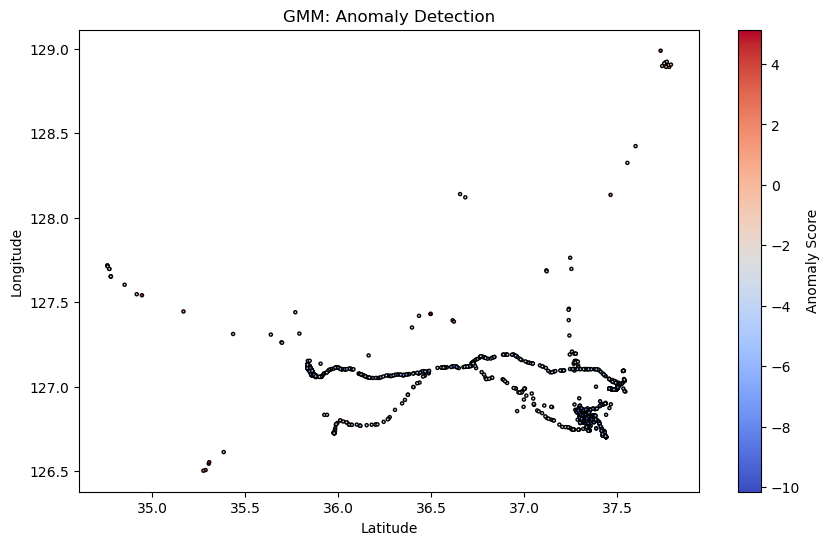

In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\1be2e43d69994758973f6185bdd973d0'

# 보간 함수 정의
def interpolate_path(path, num_points=10):
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    start_time_labels = [point[2] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    interp_start_TL = interp1d(distances, start_time_labels, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    new_TL = interp_start_TL(new_distances)
    return np.column_stack((new_latitudes, new_longitudes, new_TL))

# 모든 CSV 파일을 읽어 결합
all_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        
        # 보간 적용
        path = df[['lat', 'lng', 'time_label']].values
        interpolated_data = interpolate_path(path)
        
        # 보간된 데이터를 DataFrame으로 변환하여 추가
        interpolated_df = pd.DataFrame(interpolated_data, columns=['lat', 'lng', 'time_label'])
        all_data.append(interpolated_df)

# 모든 데이터를 하나의 DataFrame으로 결합
data = pd.concat(all_data, ignore_index=True)

# 결합된 데이터에서 결측치 제거
data = data.dropna(subset=['lat', 'lng', 'time_label'])

# lat, lng, TL 열만 선택하여 새로운 데이터 생성
X = data[['lat', 'lng', 'time_label']]

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# BIC를 사용하여 최적의 n_components와 covariance_type 찾기
def select_best_gmm(data, n_components_range, covariance_types):
    best_bic = np.inf
    best_n_components = None
    best_covariance_type = None
    best_gmm = None
    
    # n_components와 covariance_type을 모두 반복하며 최적의 조합 찾기
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            bic = gmm.bic(data)
            
            if bic < best_bic:
                best_bic = bic
                best_n_components = n_components
                best_covariance_type = covariance_type
                best_gmm = gmm
    
    return best_n_components, best_covariance_type, best_gmm, best_bic

# n_components의 범위 설정 (예시로 1부터 20까지)
n_components_range = range(1, 21)
covariance_types = ['full', 'tied', 'diag', 'spherical']  # 공분산 타입 목록

# 최적의 n_components와 covariance_type 선택
best_n_components, best_covariance_type, best_gmm, best_bic = select_best_gmm(X_train, n_components_range, covariance_types)

print(f"최적의 컴포넌트 수: {best_n_components}")
print(f"최적의 공분산 타입: {best_covariance_type}")
print(f"최적의 BIC 점수: {best_bic}")

# 테스트 데이터에 모델 적용
test_scores = best_gmm.score_samples(X_test)

# 이상 탐지 점수에 기반한 가상의 레이블 생성 (예: 상위 5%를 이상으로 간주)
threshold = np.percentile(test_scores, 5)
y_test = (test_scores < threshold).astype(int)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # GMM은 score가 높을수록 정상으로 간주되므로 부호를 반대로
auc = roc_auc_score(y_test, -test_scores)  # AUC 계산

# 최적의 임계값 찾기 (기본적으로 FPR과 TPR의 차이가 최대가 되는 임계값을 선택)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold}")
print(f"AUC: {auc}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test['lat'], X_test['lng'], c=-test_scores, cmap='coolwarm', s=5, edgecolor='k')
plt.colorbar(label='Anomaly Score')
plt.title('GMM: Anomaly Detection')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

### best parameter (운전자 - 보간 X)

Best number of components: 20
Best covariance type: full
Best BIC score: -9997835.271905592
Optimal threshold: -7.568957954532285
AUC: 1.0


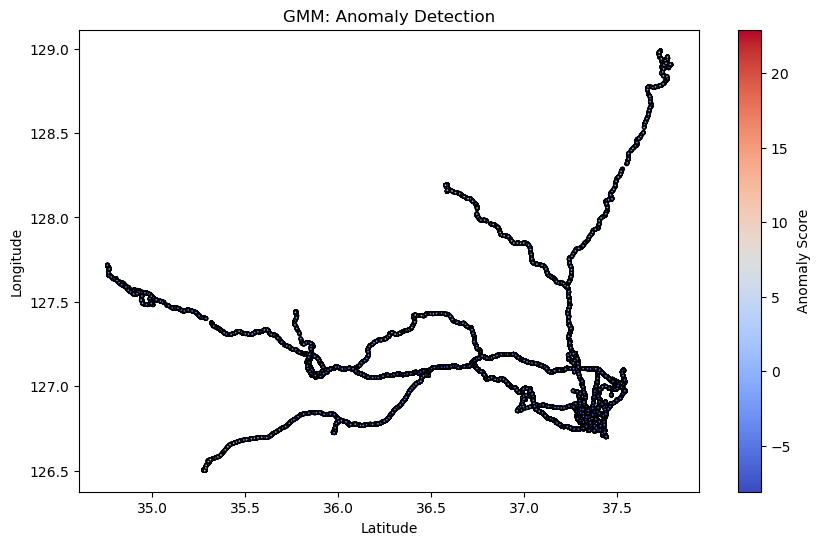

In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\1be2e43d69994758973f6185bdd973d0'

# 모든 CSV 파일을 읽어 결합
all_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        all_data.append(df)

# 모든 데이터를 하나의 DataFrame으로 결합
data = pd.concat(all_data, ignore_index=True)

# 결합된 데이터에서 결측치 제거
data = data.dropna(subset=['lat', 'lng', 'time_label'])

# lat, lng, TL 열만 선택하여 새로운 데이터 생성
X = data[['lat', 'lng', 'time_label']]

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# BIC를 사용하여 최적의 n_components와 covariance_type 찾기
def select_best_gmm(data, n_components_range, covariance_types):
    best_bic = np.inf
    best_n_components = None
    best_covariance_type = None
    best_gmm = None
    
    # n_components와 covariance_type을 모두 반복하며 최적의 조합 찾기
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
            gmm.fit(data)
            bic = gmm.bic(data)
            
            if bic < best_bic:
                best_bic = bic
                best_n_components = n_components
                best_covariance_type = covariance_type
                best_gmm = gmm
    
    return best_n_components, best_covariance_type, best_gmm, best_bic

# n_components의 범위 설정 (예시로 1부터 20까지)
n_components_range = range(1, 21)
covariance_types = ['full', 'tied', 'diag', 'spherical']  # 공분산 타입 목록

# 최적의 n_components와 covariance_type 선택
best_n_components, best_covariance_type, best_gmm, best_bic = select_best_gmm(X_train, n_components_range, covariance_types)

print(f"Best number of components: {best_n_components}")
print(f"Best covariance type: {best_covariance_type}")
print(f"Best BIC score: {best_bic}")

# 테스트 데이터에 모델 적용
test_scores = best_gmm.score_samples(X_test)

# 이상 탐지 점수에 기반한 가상의 레이블 생성 (예: 상위 5%를 이상으로 간주)
threshold = np.percentile(test_scores, 95)
y_test = (test_scores < threshold).astype(int)

# ROC 곡선 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # GMM은 score가 높을수록 정상으로 간주되므로 부호를 반대로
auc = roc_auc_score(y_test, -test_scores)  # AUC 계산

# 최적의 임계값 찾기 (기본적으로 FPR과 TPR의 차이가 최대가 되는 임계값을 선택)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")
print(f"AUC: {auc}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test['lat'], X_test['lng'], c=-test_scores, cmap='coolwarm', s=5, edgecolor='k')
plt.colorbar(label='Anomaly Score')
plt.title('GMM: Anomaly Detection')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

### start label, end label 추가

In [12]:
import os
import pandas as pd

# 새로운 파일 경로
directory = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\1be2e43d69994758973f6185bdd973d0'

# 파일에 따른 start, end TimeLabel 리스트
start_end_list = []

# 데이터 불러오기 (위도, 경도, 시간레이블)
def extract_lat_lng_TL_from_csv(directory):
    all_lat_lng_TL_lists = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = []
            for index, row in df.iterrows():
                lat_lng_list.append([row['lat'], row['lng']])
                if index == 0:
                    s = row['time_label']
                elif index == (df.shape[0] - 1):
                    e = row['time_label']
            start_end_list.append([s, e])
            all_lat_lng_TL_lists.append(lat_lng_list)
    return all_lat_lng_TL_lists

# 경로 및 시간(레이블값) 데이터
lat_lng_TL_values = extract_lat_lng_TL_from_csv(directory)

# 경로에 start, end 레이블 추가하기
for location, time in zip(lat_lng_TL_values, start_end_list):
    for point in location:
        point.extend(time)

### timestamp 추출

### 3차원 표현 - 어디쉐어 (보간 O)

453
이상치 개수: 227
이상치 좌표 (lat, lng, TL):
[[ 37.547709   126.65154      3.        ]
 [ 37.42437233 126.73735756   0.        ]
 [ 37.38290389 126.76191578   0.        ]
 [ 37.344612   126.76429367   0.        ]
 [ 37.30901078 126.75020733   0.        ]
 [ 37.27195733 126.74579078   0.        ]
 [ 37.237462   126.756948     0.        ]
 [ 37.173623   126.786432     0.        ]
 [ 37.16238411 126.793094     0.        ]
 [ 37.15114522 126.799756     0.        ]
 [ 37.13990633 126.806418     0.        ]
 [ 37.12866744 126.81308      0.        ]
 [ 37.123048   126.816411     0.        ]
 [ 37.123048   126.816411     0.        ]
 [ 37.123048   126.816411     0.        ]
 [ 37.123048   126.816411     0.        ]
 [ 37.123048   126.816411     0.        ]
 [ 36.976669   127.359655     2.        ]
 [ 37.423136   126.614294     1.        ]
 [ 37.412957   126.622776     1.        ]
 [ 37.383031   126.661314     1.        ]
 [ 37.380887   126.65990511   1.        ]
 [ 37.37969578 126.65711644   1.     

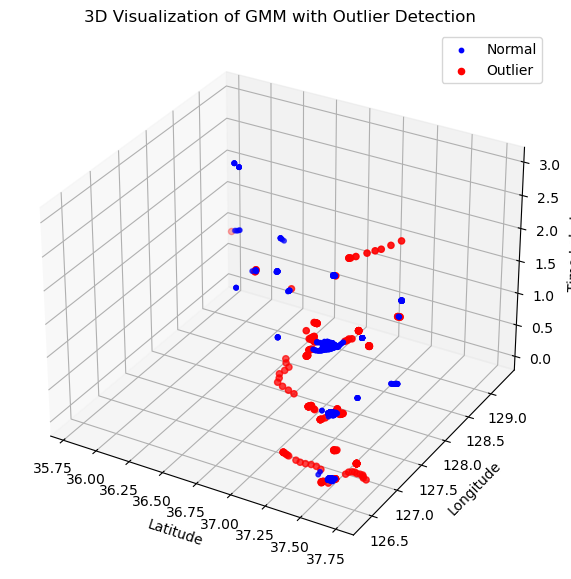

In [48]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\어디쉐어\___ecfd1086a6934ae08b555b3ae880d31e'

# 보간 함수 정의
def interpolate_path(path, num_points=10):
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    start_time_labels = [point[2] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    interp_start_TL = interp1d(distances, start_time_labels, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    new_TL = interp_start_TL(new_distances)
    return np.column_stack((new_latitudes, new_longitudes, new_TL))

# 모든 CSV 파일을 읽어 결합
all_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        
        # 보간 적용
        path = df[['lat', 'lng', 'TL']].values
        interpolated_data = interpolate_path(path)
        
        # 보간된 데이터를 DataFrame으로 변환하여 추가
        interpolated_df = pd.DataFrame(interpolated_data, columns=['lat', 'lng', 'TL'])
        all_data.append(interpolated_df)
        
# 모든 데이터를 하나의 DataFrame으로 결합
data = pd.concat(all_data, ignore_index=True)

# 결합된 데이터에서 결측치 제거
data = data.dropna(subset=['lat', 'lng', 'TL'])

# lat, lng, TL 열만 선택하여 새로운 데이터 생성
X = data[['lat', 'lng', 'TL']].values

# Gaussian Mixture Model 학습
gmm = GaussianMixture(n_components=20, covariance_type='full', random_state=42)
gmm.fit(X)

# 각 데이터 포인트에 대한 로그 확률 계산
log_probs = gmm.score_samples(X)

# 로그 확률의 임계값 설정 (예: 하위 5%를 이상치로 간주)
threshold = np.percentile(log_probs, 5)

# 이상치 탐지 (로그 확률이 임계값보다 작은 경우 이상치로 간주)
outliers = log_probs < threshold

# 정상치와 이상치 분리
normal_data = X[~outliers]
outlier_data = X[outliers]

# 이상치 개수와 값 출력
print(f"이상치 개수: {len(outlier_data)}")
print("이상치 좌표 (lat, lng, TL):")
print(outlier_data)

# 전체 데이터의 개수
total_data_points = len(X)

# 이상치 비율 계산
anomaly_percentage = (len(outlier_data) / total_data_points) * 100

# 전체 데이터 양 및 이상치 비율 출력
print(f"전체 데이터 포인트 수: {total_data_points}")
print(f"이상치가 전체 데이터에서 차지하는 비율: {anomaly_percentage:.2f}%")

# 3D 시각화 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 정상치 (파란색)
ax.scatter(normal_data[:, 0], normal_data[:, 1], normal_data[:, 2], c='blue', s=10, label='Normal')

# 이상치 (빨간색)
ax.scatter(outlier_data[:, 0], outlier_data[:, 1], outlier_data[:, 2], c='red', s=20, label='Outlier')

# 축 레이블 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Time Label')

# 그래프 제목 및 범례 설정
ax.set_title('3D Visualization of GMM with Outlier Detection')
ax.legend()

# 그래프 보여주기
plt.show()

전체 경로 수: 453
이상치 경로 수: 32
이상치 비율: 7.06401766004415


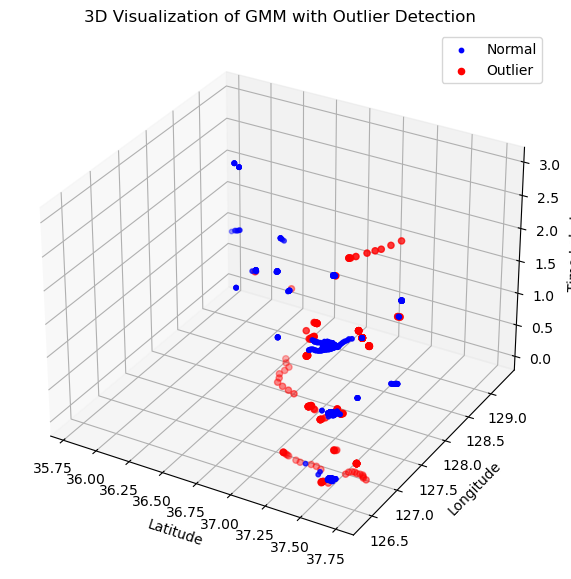

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\어디쉐어\___ecfd1086a6934ae08b555b3ae880d31e'

# 보간 함수 정의
def interpolate_path(path, num_points=10):
    if len(path) < 2:  # 최소 두 점이 필요
        return path  # 보간할 수 없으므로 원래 데이터를 반환
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    start_time_labels = [point[2] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    interp_start_TL = interp1d(distances, start_time_labels, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    new_TL = interp_start_TL(new_distances)
    return np.column_stack((new_latitudes, new_longitudes, new_TL))

# 모든 CSV 파일을 읽어 결합
all_paths = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        
        # 보간 적용
        path = df[['lat', 'lng', 'TL']].values
        interpolated_data = interpolate_path(path)
        
        # 보간된 데이터와 파일명을 함께 저장
        all_paths.append((interpolated_data, filename))

# 모든 데이터를 하나의 DataFrame으로 결합
data = np.vstack([path for path, _ in all_paths])

# Gaussian Mixture Model 학습
gmm = GaussianMixture(n_components=19, covariance_type='full', random_state=42)
gmm.fit(data)

# 각 데이터 포인트에 대한 로그 확률 계산
log_probs = gmm.score_samples(data)

# 로그 확률의 임계값 설정 (예: 하위 5%를 이상치로 간주)
threshold = np.percentile(log_probs, 5)

# 이상치 탐지 (로그 확률이 임계값보다 작은 경우 이상치로 간주)
outliers = log_probs < threshold

# 이상치 경로 세기
outlier_paths = set()
for i, (path, filename) in enumerate(all_paths):
    if any(outliers[i * 10:(i + 1) * 10]):  # 각 파일당 10개의 보간 포인트
        outlier_paths.add(filename)

# 이상치 경로 출력
print(f"전체 경로 수: {len(all_paths)}")
print(f"이상치 경로 수: {len(outlier_paths)}")
#print("이상치 경로 파일 이름:")
#print(outlier_paths)

# 이상치 비율 계산
anomaly_percentage = (len(outlier_paths) / len(all_paths)) * 100

# 이상치 비율 출력
print(f"이상치 비율: {anomaly_percentage}")

# 3D 시각화 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 정상치 (파란색)
ax.scatter(data[~outliers][:, 0], data[~outliers][:, 1], data[~outliers][:, 2], c='blue', s=10, label='Normal')

# 이상치 (빨간색)
ax.scatter(data[outliers][:, 0], data[outliers][:, 1], data[outliers][:, 2], c='red', s=20, label='Outlier')

# 축 레이블 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Time Label')

# 그래프 제목 및 범례 설정
ax.set_title('3D Visualization of GMM with Outlier Detection')
ax.legend()

# 그래프 보여주기
plt.show()

### 3차원 표현 - 어디쉐어 (보간 X)

이상치 개수: 905
이상치 좌표 (lat, lng, TL):
[[ 37.4333   126.727103   0.      ]
 [ 37.433245 126.72797    0.      ]
 [ 37.433164 126.729265   0.      ]
 ...
 [ 37.523485 127.015619   3.      ]
 [ 37.511416 127.000507   3.      ]
 [ 37.511416 127.000507   3.      ]]
전체 데이터 포인트 수: 18087
이상치가 전체 데이터에서 차지하는 비율: 5.00%


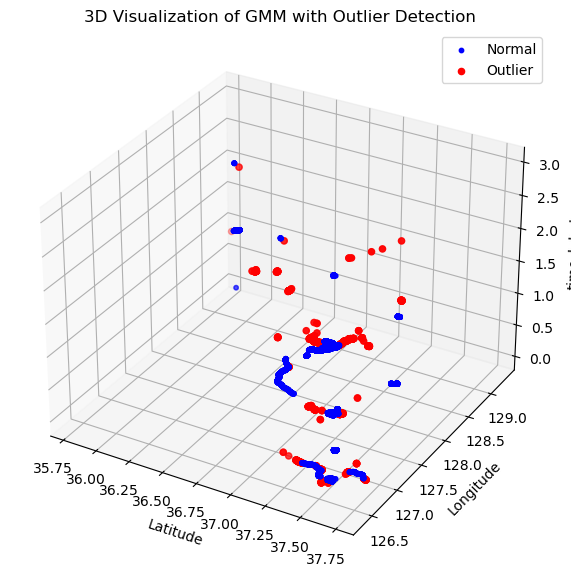

In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 데이터 파일 경로 설정
data_folder = r"C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\어디쉐어\___ecfd1086a6934ae08b555b3ae880d31e"

# 모든 CSV 파일 읽어오기
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

# 데이터 프레임 리스트에 모든 파일의 데이터를 추가
df_list = [pd.read_csv(file) for file in all_files]

# 하나의 데이터 프레임으로 병합
data = pd.concat(df_list, ignore_index=True)

# lat, lng, TL 열 사용
lat = data['lat'].values
lng = data['lng'].values
tl = data['TL'].values

# 데이터 준비 완료
X = np.column_stack((lat, lng, tl))

# Gaussian Mixture Model 학습
gmm = GaussianMixture(n_components=19, covariance_type='full', random_state=42)
gmm.fit(X)

# 각 데이터 포인트에 대한 로그 확률 계산
log_probs = gmm.score_samples(X)

# 로그 확률의 임계값 설정 (예: 하위 5%를 이상치로 간주)
threshold = np.percentile(log_probs, 5)

# 이상치 탐지 (로그 확률이 임계값보다 작은 경우 이상치로 간주)
outliers = log_probs < threshold

# 정상치와 이상치 분리
normal_data = X[~outliers]
outlier_data = X[outliers]

# 이상치 개수와 값 출력
print(f"이상치 개수: {len(outlier_data)}")
print("이상치 좌표 (lat, lng, TL):")
print(outlier_data)

# 전체 데이터의 개수
total_data_points = len(X)

# 이상치 비율 계산
anomaly_percentage = (len(outlier_data) / total_data_points) * 100

# 전체 데이터 양 및 이상치 비율 출력
print(f"전체 데이터 포인트 수: {total_data_points}")
print(f"이상치가 전체 데이터에서 차지하는 비율: {anomaly_percentage:.2f}%")

# 3D 시각화 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 정상치 (파란색)
ax.scatter(normal_data[:, 0], normal_data[:, 1], normal_data[:, 2], c='blue', s=10, label='Normal')

# 이상치 (빨간색)
ax.scatter(outlier_data[:, 0], outlier_data[:, 1], outlier_data[:, 2], c='red', s=20, label='Outlier')

# 축 레이블 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('time_label')

# 그래프 제목 및 범례 설정
ax.set_title('3D Visualization of GMM with Outlier Detection')
ax.legend()

# 그래프 보여주기
plt.show()

### 3차원 표현 - 위드라이브 (보간 O)

전체 경로 수: 703
이상치 경로 수: 90
이상치 비율: 12.802275960170698


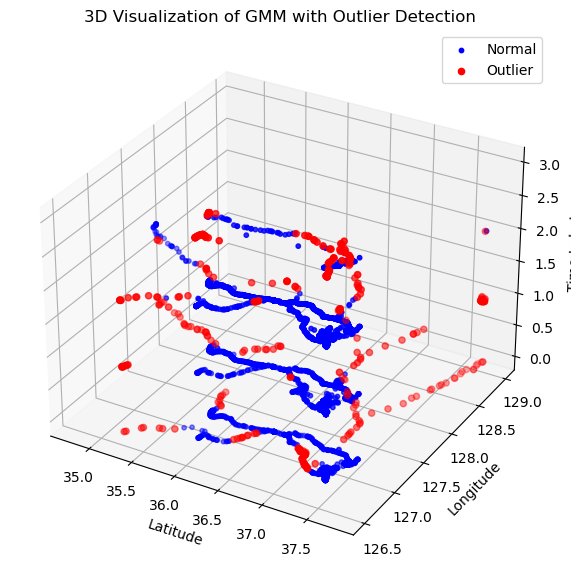

In [54]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

# 데이터 폴더 경로 설정
directory_path = r'C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\1be2e43d69994758973f6185bdd973d0'

# 보간 함수 정의
def interpolate_path(path, num_points=10):
    if len(path) < 2:  # 최소 두 점이 필요
        return path  # 보간할 수 없으므로 원래 데이터를 반환
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    start_time_labels = [point[2] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    interp_start_TL = interp1d(distances, start_time_labels, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    new_TL = interp_start_TL(new_distances)
    return np.column_stack((new_latitudes, new_longitudes, new_TL))

# 모든 CSV 파일을 읽어 결합
all_paths = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        
        # 보간 적용
        path = df[['lat', 'lng', 'time_label']].values
        interpolated_data = interpolate_path(path)
        
        # 보간된 데이터와 파일명을 함께 저장
        all_paths.append((interpolated_data, filename))

# 모든 데이터를 하나의 DataFrame으로 결합
data = np.vstack([path for path, _ in all_paths])

# Gaussian Mixture Model 학습
gmm = GaussianMixture(n_components=19, covariance_type='full', random_state=42)
gmm.fit(data)

# 각 데이터 포인트에 대한 로그 확률 계산
log_probs = gmm.score_samples(data)

# 로그 확률의 임계값 설정 (예: 하위 5%를 이상치로 간주)
threshold = np.percentile(log_probs, 5)

# 이상치 탐지 (로그 확률이 임계값보다 작은 경우 이상치로 간주)
outliers = log_probs < threshold

# 이상치 경로 세기
outlier_paths = set()
for i, (path, filename) in enumerate(all_paths):
    if any(outliers[i * 10:(i + 1) * 10]):  # 각 파일당 10개의 보간 포인트
        outlier_paths.add(filename)

# 이상치 경로 출력
print(f"전체 경로 수: {len(all_paths)}")
print(f"이상치 경로 수: {len(outlier_paths)}")
#print("이상치 경로 파일 이름:")
#print(outlier_paths)

# 이상치 비율 계산
anomaly_percentage = (len(outlier_paths) / len(all_paths)) * 100

# 이상치 비율 출력
print(f"이상치 비율: {anomaly_percentage}")

# 3D 시각화 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 정상치 (파란색)
ax.scatter(data[~outliers][:, 0], data[~outliers][:, 1], data[~outliers][:, 2], c='blue', s=10, label='Normal')

# 이상치 (빨간색)
ax.scatter(data[outliers][:, 0], data[outliers][:, 1], data[outliers][:, 2], c='red', s=20, label='Outlier')

# 축 레이블 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Time Label')

# 그래프 제목 및 범례 설정
ax.set_title('3D Visualization of GMM with Outlier Detection')
ax.legend()

# 그래프 보여주기
plt.show()

### 3차원 표현 - 위드라이브 (보간 X)

이상치 개수: 60528
이상치 좌표 (lat, lng, TL):
[[ 36.9167707 127.0095704   1.       ]
 [ 36.9163732 127.009962    1.       ]
 [ 36.9159821 127.0103464   1.       ]
 ...
 [ 36.089055  126.7752245   3.       ]
 [ 36.0895581 126.775232    3.       ]
 [ 36.090058  126.7752417   3.       ]]
전체 데이터 포인트 수: 1210551
이상치가 전체 데이터에서 차지하는 비율: 5.00%


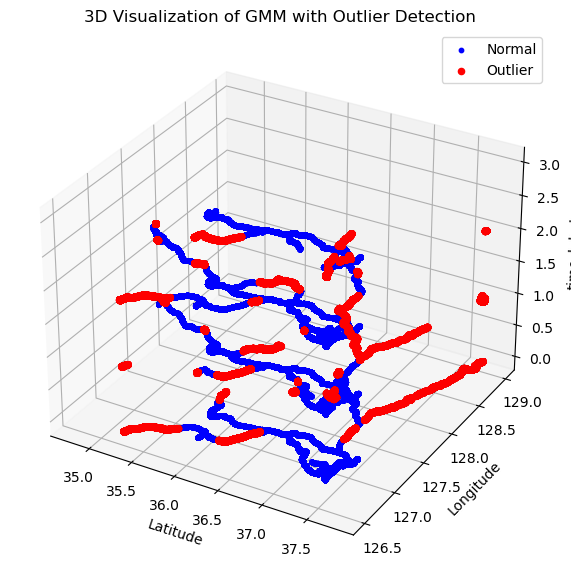

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 데이터 파일 경로 설정
data_folder = r"C:\Users\d\OneDrive - 충북대학교\바탕 화면\RTP2\1be2e43d69994758973f6185bdd973d0"

# 모든 CSV 파일 읽어오기
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

# 데이터 프레임 리스트에 모든 파일의 데이터를 추가
df_list = [pd.read_csv(file) for file in all_files]

# 하나의 데이터 프레임으로 병합
data = pd.concat(df_list, ignore_index=True)

# lat, lng, TL 열 사용
lat = data['lat'].values
lng = data['lng'].values
tl = data['time_label'].values

# 데이터 준비 완료
X = np.column_stack((lat, lng, tl))

# Gaussian Mixture Model 학습
gmm = GaussianMixture(n_components=19, covariance_type='full', random_state=42)
gmm.fit(X)

# 각 데이터 포인트에 대한 로그 확률 계산
log_probs = gmm.score_samples(X)

# 로그 확률의 임계값 설정 (예: 하위 5%를 이상치로 간주)
threshold = np.percentile(log_probs, 5)

# 이상치 탐지 (로그 확률이 임계값보다 작은 경우 이상치로 간주)
outliers = log_probs < threshold

# 정상치와 이상치 분리
normal_data = X[~outliers]
outlier_data = X[outliers]

# 이상치 개수와 값 출력
print(f"이상치 개수: {len(outlier_data)}")
print("이상치 좌표 (lat, lng, TL):")
print(outlier_data)

# 전체 데이터의 개수
total_data_points = len(X)

# 이상치 비율 계산
anomaly_percentage = (len(outlier_data) / total_data_points) * 100

# 전체 데이터 양 및 이상치 비율 출력
print(f"전체 데이터 포인트 수: {total_data_points}")
print(f"이상치가 전체 데이터에서 차지하는 비율: {anomaly_percentage:.2f}%")

# 3D 시각화 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 정상치 (파란색)
ax.scatter(normal_data[:, 0], normal_data[:, 1], normal_data[:, 2], c='blue', s=10, label='Normal')

# 이상치 (빨간색)
ax.scatter(outlier_data[:, 0], outlier_data[:, 1], outlier_data[:, 2], c='red', s=20, label='Outlier')

# 축 레이블 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('time_label')

# 그래프 제목 및 범례 설정
ax.set_title('3D Visualization of GMM with Outlier Detection')
ax.legend()

# 그래프 보여주기
plt.show()